<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [108]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [109]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '../capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [110]:
def to_sparse(X):
    indptr = [0] # pointer array of the matrix
    indices = [] # array of the matrix
    data = [] # data array of the matrix
    vocabulary = {}
    for session in X:
         for site_id in session:
                
             # добавляем его индекс, если это не 0. нумерацию смещаем на -1
             if site_id !=0:
                    
                 indices.append(site_id-1)               
                 #
                 data.append(1)
                
         # добавляем в список указателей длинну списка индексов       
         indptr.append(len(indices))
    csr_m = csr_matrix((data, indices, indptr), dtype=int)
    return csr_m


def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    
    # list of csv files
    file_list = glob('{}/*'.format(path_to_csv_files))
    file_list.sort()
       
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
      
    # dafaframe
    train_data_rows = []

    for user, file in tqdm_notebook(enumerate(file_list)):
        data = pd.read_csv(file)
        
        # to timestamps
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        
        # index intervals for sessions
        intervals = []
        x = 0     
        while True:
            if x + session_length < data.shape[0]:
                intervals.append((x, x + session_length - 1))
                x += session_length
            else:
                intervals.append((x, data.shape[0] - 1))
                break
        
        for start, finish in intervals:
            
            # make empty session
            session = [0] * session_length
                   
            uniques = set()
            for i, site in enumerate(list(data.iloc[start:finish+1, 1])):
                session[i] = site_freq[site][0]
                uniques.add(site_freq[site][0])
                       
            # feature engineering  
            
            # 1. session_timespan – продолжительность сессии 
            # разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах
            diff = int((data.iloc[finish,0] - data.iloc[start,0]) / np.timedelta64(1, 's'))
            session.append(diff)

            # 2. unique_sites – число уникальных сайтов в сессии
            session.append(len(uniques))
            
            # 3. start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)
            session.append(data.iloc[start, 0].hour)
            
            # 4. day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти)
            session.append(data.iloc[start, 0].dayofweek)
            # adding target
            session += [user + 1]
            
            train_data_rows.append(session)
    
    train_data = pd.DataFrame(np.array(train_data_rows), columns=feature_names)
    
    # X,y split
    # X, y = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
    
    # convert to sparse matrix
    # X_sparse = to_sparse(X)

    return train_data

**Проверим функцию на игрушечном примере.**

In [ ]:
# feature_names = ['site' + str(i) for i in range(1,11)] + \
#                 ['time_diff' + str(j) for j in range(1,10)] + \
#                 ['session_timespan', '#unique_sites', 'start_hour', 
#                  'day_of_week', 'target']

feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [561]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,1471,3,12,4,3


In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [562]:
# %%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

In [563]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,33,5,8,4,1
1,415,193,674,254,133,31,393,3305,217,55,284,10,8,4,1
2,55,3,55,55,5,293,415,333,897,55,258,7,8,4,1
3,473,3306,473,55,55,55,55,937,199,123,30,6,8,4,1
4,342,55,5,3307,258,211,3308,2086,675,2086,6,9,8,4,1


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [564]:
# %%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [565]:
new_features_10users = train_data_10users[["session_timespan", "#unique_sites", "start_hour", "day_of_week"]]
new_features_150users = train_data_150users[["session_timespan", "#unique_sites", "start_hour", "day_of_week"]]

In [566]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [567]:
print('Медианная продолжительность сессии -', train_data_10users['session_timespan'].median(), 'сек.')

Медианная продолжительность сессии - 37.0 сек.


**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [568]:
print('Медианный день недели -', int(train_data_10users['day_of_week'].median()))

Медианный день недели - 2


**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [569]:
print('Медианный час начала сессии для сессий 150 пользователей -', train_data_150users['start_hour'].median())

Медианный час начала сессии для сессий 150 пользователей - 13.0


**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [570]:
print('Медианное значение числа уникальных сайтов -', train_data_150users['#unique_sites'].median())

Медианное значение числа уникальных сайтов - 7.0


## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [571]:
# id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
#                33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}

id_name_dict = {1: 'Mary-Kate', 2: 'Ashley', 3: 'Lindsey', 4: 'Naomi', 5: 'Avril',
               6: 'Bob', 7: 'Bill', 8: 'John', 9: 'Dick', 10: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [572]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

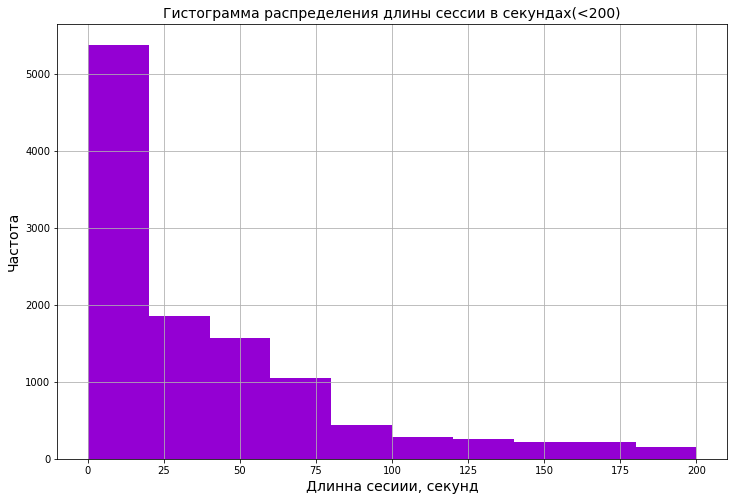

In [573]:
st_200 = train_data_10users['session_timespan'][train_data_10users['session_timespan'] <=200]

plt.figure(figsize=(12,8))
plt.title('Гистограмма распределения длины сессии в секундах(<200)', size=14)
st_200.hist(color='darkviolet')
plt.xlabel('Длинна сесиии, секунд', size=14)
plt.ylabel('Частота', size=14)
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

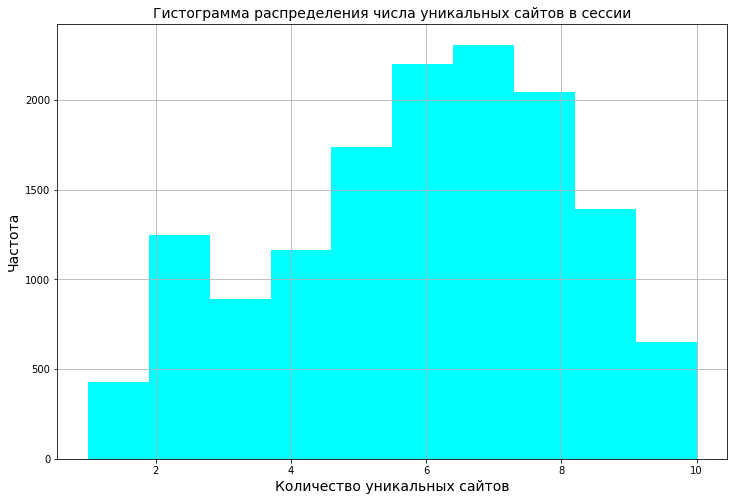

In [574]:
plt.figure(figsize=(12,8))
plt.title('Гистограмма распределения числа уникальных сайтов в сессии', size=14)
train_data_10users['#unique_sites'].hist(color='aqua')
plt.xlabel('Количество уникальных сайтов', size=14)
plt.ylabel('Частота', size=14)
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

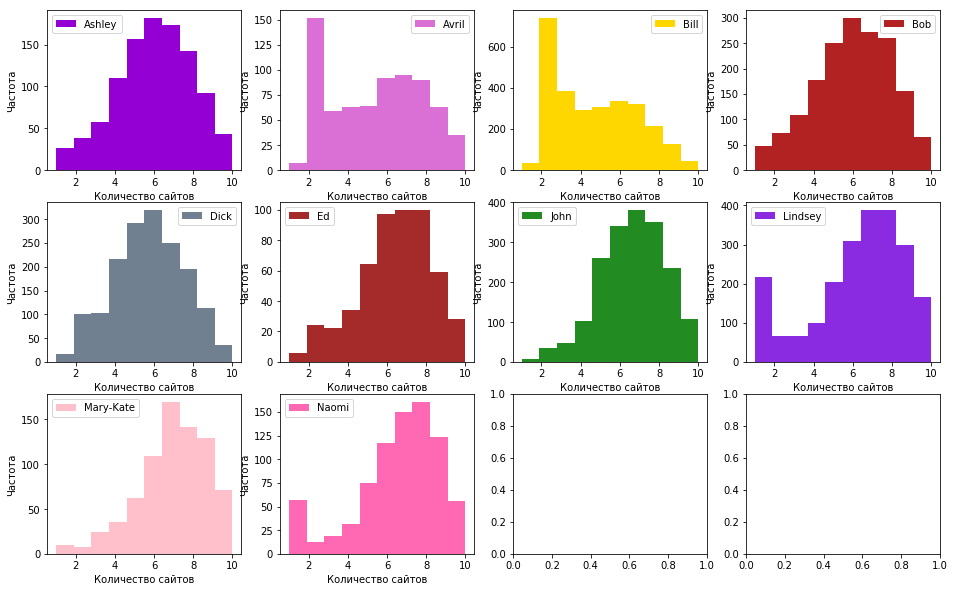

In [575]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for i, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    axes[i//4, i%4].hist(sub_df['#unique_sites'], color=color_dic[user], label=user)
    axes[i//4, i%4].legend()
    axes[i//4, i%4].set_xlabel('Количество сайтов', size=10)
    axes[i//4, i%4].set_ylabel('Частота', size=10)

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

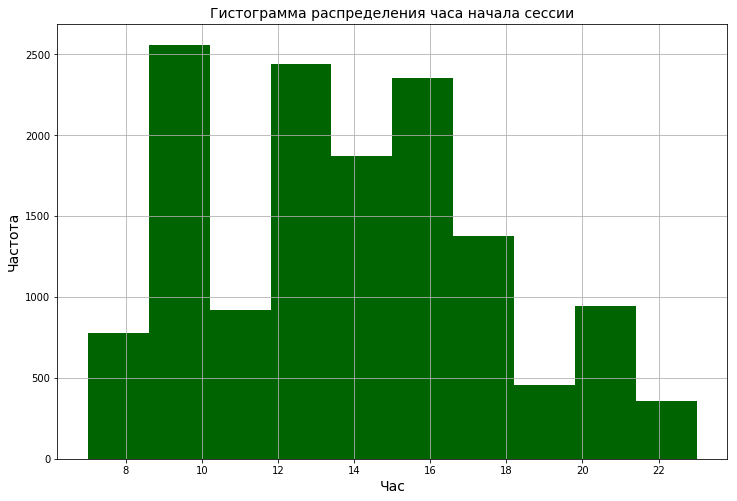

In [576]:
plt.figure(figsize=(12,8))
plt.title('Гистограмма распределения часа начала сессии', size=14)
train_data_10users['start_hour'].hist(color='darkgreen')
plt.xlabel('Час', size=14)
plt.ylabel('Частота', size=14)
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

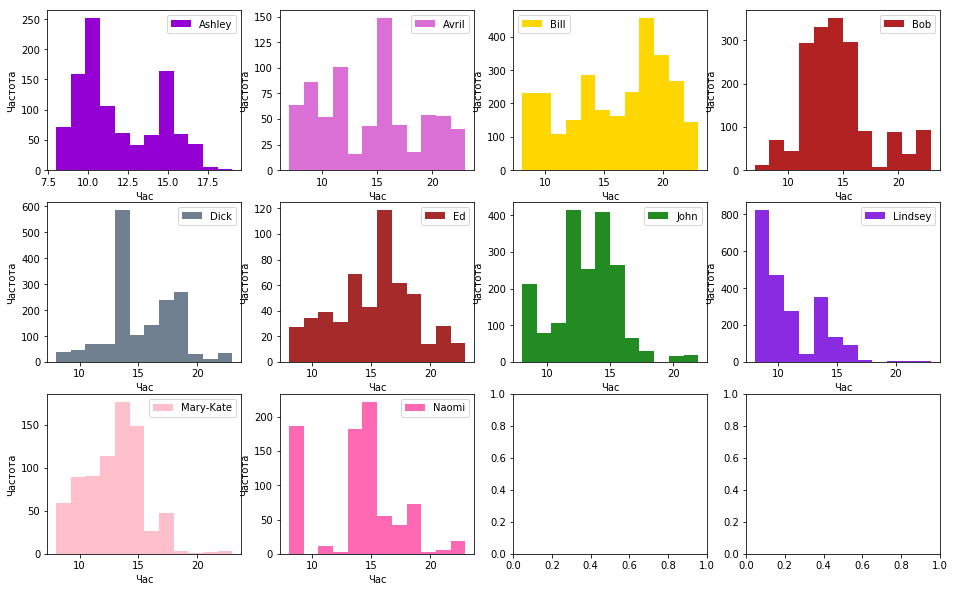

In [577]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for i, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    axes[i//4, i%4].hist(sub_df['start_hour'], color=color_dic[user], label=user, bins=12)
    axes[i//4, i%4].legend()
    axes[i//4, i%4].set_xlabel('Час', size=10)
    axes[i//4, i%4].set_ylabel('Частота', size=10)

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

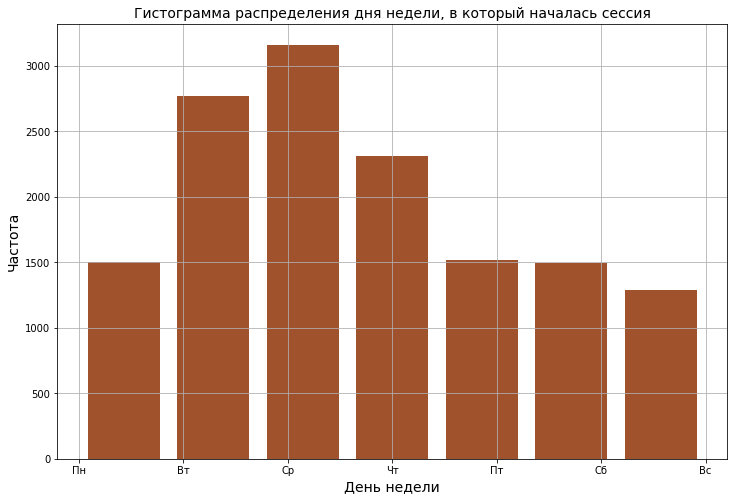

In [578]:
plt.figure(figsize=(12,8))
plt.title('Гистограмма распределения дня недели, в который началась сессия', size=14)
train_data_10users['day_of_week'].hist(color='sienna', bins=7, rwidth=0.8)
plt.xticks(list(range(0,7)),['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.xlabel('День недели', size=14)
plt.ylabel('Частота', size=14)
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

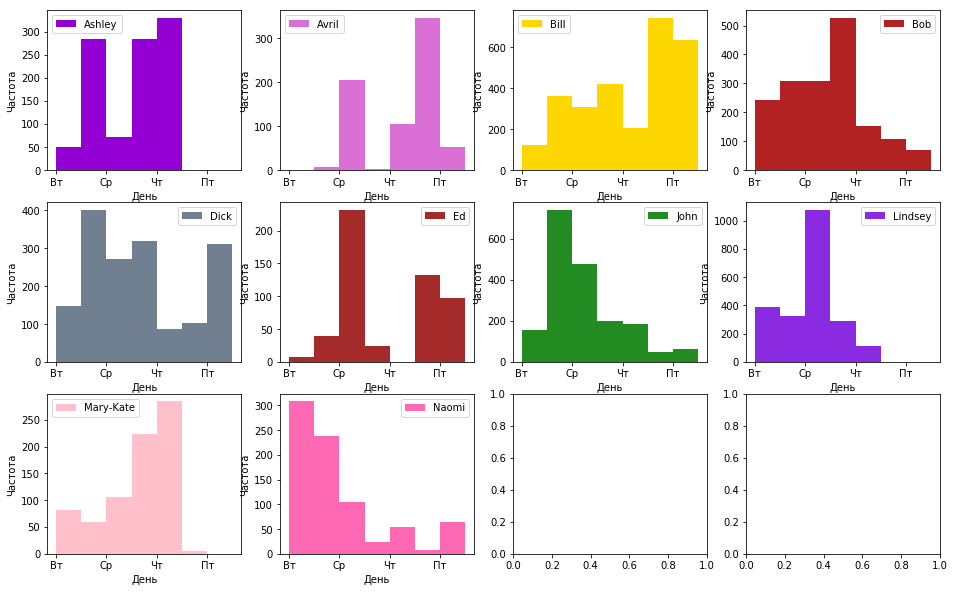

In [579]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
for i, (user, sub_df) in enumerate(train_data_10users.groupby('target')):
    axes[i//4, i%4].hist(sub_df['day_of_week'], color=color_dic[user], label=user, bins=range(0,8))
    axes[i//4, i%4].legend()
    axes[i//4, i%4].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    axes[i//4, i%4].set_xlabel('День', size=10)
    axes[i//4, i%4].set_ylabel('Частота', size=10)

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

- Mary-Kate:
чаще всего посещает по 7 уникальных сайтов за сессию, обычно c 9 утра до 3-х часов дня. По будням, больше всего в четверг и пятницу.
- Ashley:
чаще всего посещает по 6 уникальных сайтов за сессию, обычно до 12 утра и около 16:00. Сессии приходятся на вторник, четверг и пятницу.
- Lindsey:
чаще всего посещает по 7-8 уникальных сайтов за сессию, обычно до 10 утра и около 14:00. Исключительно по будням, с пиком в среду.
- Naomi:
чаще всего посещает по 8 уникальных сайтов за сессию, обычно до около 9 утра и с 13 до 15 часов. Чаще всего в понедельник и вторник.
- Avril:
чаще всего посещает по 2 уникальных сайта за сессию, обычно до 10 утра и около 16:00 и после 20:00. Как правило, в среду и субботу.
- Bob:
чаще всего посещает по 6 уникальных сайтов за сессию, обычно с 11 до 16. Как правило, в буднии дни с пиком в четверг.
- Bill:
чаще всего посещает по 2 уникальных сайта за сессию, в основном после 18:00 и понемногу в течение дня. В течение всей недели, но больше всего на выходных.
- John:
чаще всего посещает по 7 уникальных сайтов за сессию, обычно с 11 до 16. По будням, но чаще всего во вторник и среду.
- Dick:
чаще всего посещает по 6 уникальных сайтов за сессию, чаще всего около 14:00 и около 18:00. Наиболее часто в со вторника по четверг и в воскресенье.
- Ed:
чаще всего посещает по 7-8 уникальных сайтов за сессию, с 9 утра до 19 с пиком около 16 часов. Сессии  приходятся на среду и выходные дни.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [580]:
with open('site_freq_10users.pkl', 'rb') as f:
    site_freq_10users = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [581]:
top10_freqs = [v[1] for site, v in site_freq_10users.items()][:10]
top10_sites = [site for site, v in site_freq_10users.items()][:10]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

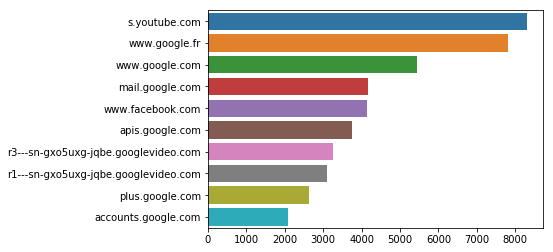

In [582]:
sns.barplot(x=top10_freqs, y=top10_sites)

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [583]:
def feature_engineering(path_to_csv_files, site_freq_path, features, session_length=10):
    
    # list of csv files
    file_list = glob('{}/*'.format(path_to_csv_files))
    file_list.sort()
      
    # dafaframe
    train_data_rows = []
    
    # топ30 и топ100 по частотам.
    with open(site_freq_path, 'rb') as f:
        site_freq = pickle.load(f)
    below_30 = [site for site, v in site_freq.items()][:30]
    below_100 = [site for site, v in site_freq.items()][:100]
        

    for user, file in tqdm_notebook(enumerate(file_list)):
        data = pd.read_csv(file)
        
        # to timestamps
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        
        # index intervals for sessions
        intervals = []
        x = 0     
        while True:
            if x + session_length < data.shape[0]:
                intervals.append((x, x + session_length - 1))
                x += session_length
            else:
                intervals.append((x, data.shape[0] - 1))
                break
        
        for start, finish in intervals:
            # interval data
            df = data.iloc[start:finish+1, :]
            
            # 1. Добавим time_diff - разницу во времени между посещениями сайтов, как в примере.           
            row = [-1]*9 
            for i in range(0, df.shape[0]-1):
                diff = int((df.iloc[i+1, 0] - df.iloc[i, 0]) / np.timedelta64(1, 's'))
                row[i]= diff
            
            # 2. mean и max для time_diff. mean для ненулевых значений
            mean = np.mean(list(filter(lambda x: x >= 0, row)))
            row.append(mean)
            row.append(np.max(row))
            
            # 2. mean и max для time_diff. mean для ненулевых значений
            row.append(1 if mean < 1 else 0)

            
            # 3. Посещение Google и Facebook, раз
            gfy_count = 0
            for site in df['site']:
                if ('google' or 'facebook' or 'youtube') in site:
                    gfy_count +=1
            row += [gfy_count]
            
            # 4. Если за сессию ни разу не посетили Google и Facebook.
            row.append(1 if gfy_count==0 else 0)
    
            # 5. ни разу не посетили страницу из топ30 и топ100 по частотам.
            for site in df['site']:
                if site in below_30:
                    row.append(0)
                    break
            else:
                row.append(1)
                
            for site in df['site']:
                if site in below_100:
                    row.append(0)
                    break
            else:
                row.append(1)
            
            train_data_rows.append(row)
            
    train_data = pd.DataFrame(np.array(train_data_rows), columns=features)
    
    return train_data


In [584]:
# 1. Добавим time_diff - разницу во времени между посещениями сайтов, как в примере. 
# только дефолтом(там где нет значения) сделаем -1, нужно чтобы отслеживать время короче секунды
# 2. mean и max для time_diff. mean для значений кроме -1
# 3. Если time_diff_mean < 1 секунды, бинарный
# 4. Посещение Google, Youtube или Facebook(любой из трех), кол-во раз 
# 5. Ни разу не посетили Google, Facebook или Youtube.
# 6. Ни разу не посетили страницу из топ30 и топ100 по частотам.

features = ['time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5', 
            'time_diff6', 'time_diff7', 'time_diff8','time_diff9',
            'time_diff_mean','time_diff_max', 'time_diff_mean<1',
            'visits_gfy', 'no_gfy',
            'no_top30', 'no_top100']

In [585]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'),
                                           os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                           features, session_length=10)

In [586]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'),
                                            os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                            features, session_length=10)

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

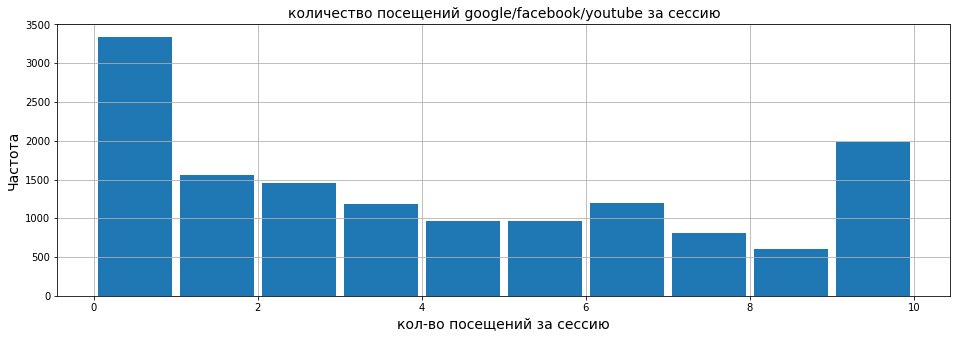

In [587]:
plt.figure(figsize=(16,5))
plt.title('количество посещений google/facebook/youtube за сессию', size=14)
new_features_10users['visits_gfy'].hist(bins=range(11),rwidth=0.9)
plt.xlabel('кол-во посещений за сессию', size=14)
plt.ylabel('Частота', size=14)
plt.show()

In [588]:
print('доля сессий когда google/facebook/youtube не посещались', new_features_10users['no_gfy'].mean())

доля сессий когда google/facebook/youtube не посещались 0.2374653296351611


По гистограммам видно, что значительная часть сессий включает посещение данных сайтов(76%). Часто - только эти сайты.

In [589]:
print('доля сессий когда топ30 не посещались', new_features_10users['no_top30'].mean())
print('доля сессий когда топ100 не посещались', new_features_10users['no_top100'].mean())

доля сессий когда топ30 не посещались 0.11471445843112155
доля сессий когда топ100 не посещались 0.03563046724983998


Оставим эти признаки. Могут помочь в поисках аномалий.

среднее для наибольшей разности во времени между посещениями за сессию -  7876.837 сек.
медиана для наибольшей разности во времени между посещениями за сессию -  14.0 сек.


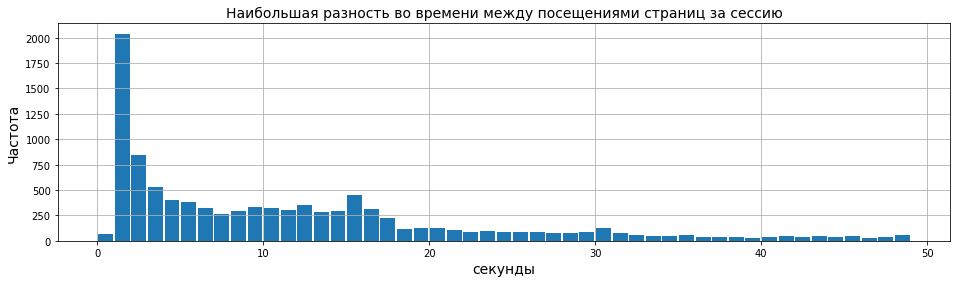

среднее для средней разности во времени между посещениями за сессию -  945.104 сек.
медиана для средней разности во времени между посещениями за сессию -  4.111 сек.


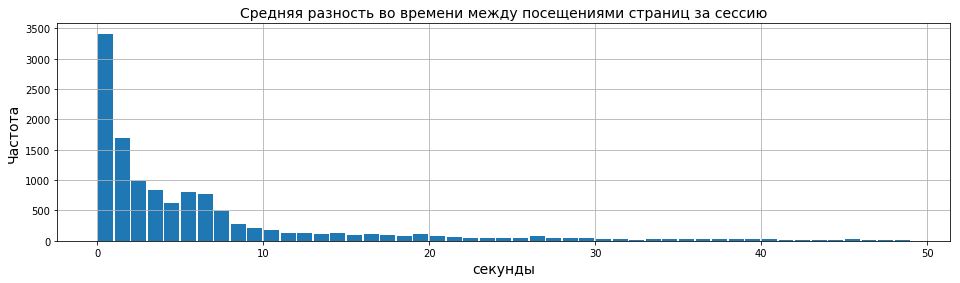

In [590]:
print('среднее для наибольшей разности во времени между посещениями за сессию - ', 
      round(new_features_10users['time_diff_max'].mean(), 3), 'сек.')
print('медиана для наибольшей разности во времени между посещениями за сессию - ', 
      round(new_features_10users['time_diff_max'].median(), 3), 'сек.')

plt.figure(figsize=(16,4))
plt.title('Наибольшая разность во времени между посещениями страниц за сессию', size=14)
new_features_10users['time_diff_max'].hist(bins=range(50),rwidth=0.9)
plt.xlabel('секунды', size=14)
plt.ylabel('Частота', size=14)
plt.show()

print('среднее для средней разности во времени между посещениями за сессию - ', 
      round(new_features_10users['time_diff_mean'].mean(), 3), 'сек.')
print('медиана для средней разности во времени между посещениями за сессию - ', 
      round(new_features_10users['time_diff_mean'].median(), 3), 'сек.')

plt.figure(figsize=(16,4))
plt.title('Средняя разность во времени между посещениями страниц за сессию', size=14)
new_features_10users['time_diff_mean'].hist(bins=range(50),rwidth=0.9)
plt.xlabel('секунды', size=14)
plt.ylabel('Частота', size=14)
plt.show()

In [591]:
print('доля сессий где средняя разность по времени между сайтами меньше 1 секунды:', 
      new_features_10users['time_diff_mean<1'].mean())

доля сессий где средняя разность по времени между сайтами меньше 1 секунды: 0.24279923191807126


данные признаки могут пригодится. Оставим данные признаки.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [592]:
f = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target'] + features
selected_features_10users = f
selected_features_150users = f

In [593]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 